In [128]:
from init_mnist import init, load
import numpy as np

In [129]:
# in case that dataset is missing or pickle is broken uncomment this
# init()

x_train, y_train, x_test, y_test = load()

# take first 1000 samples
x_train = x_train[0:1000]
y_train = y_train[0:1000]

# transform labels from [2] to [0,0,1,0,0,0,0,0,0,0]
OUT_CLASSES = 10

transformed_y_train = []

for y_label in y_train:
    zero = np.zeros((OUT_CLASSES,))
    zero[y_label] = 1
    transformed_y_train.append(zero)

y_train = transformed_y_train

transformed_y_test = []

for y_label in y_test:
    zero = np.zeros((OUT_CLASSES,))
    zero[y_label] = 1
    transformed_y_test.append(zero)

y_test = transformed_y_test

# normalize input, avoid divergence
x_train = x_train / 255
x_test = x_test / 255

In [130]:
len(x_test[0])

784

In [131]:
def relu(x):
    return (x > 0) * x

def relu_deriv(x):
    return x > 0

def predict(input_data, weights):
    # input dot weights between 0 and 1 layer
    # (1, 783) dot (738, 30) -> (1, 30)
    layer_1 = relu(np.dot(input_data, weights[0]))
    # output from layer 1 dot weights between 1 and 2 layer
    # (1, 30) dot (30, 10) -> (1, 10)
    layer_2 = np.dot(layer_1, weights[1])
    
    return layer_1, layer_2

# calculate accuracy
def accuracy(x_train, y_train, weights):
    match = 0
    for input_, label in zip(x_train, y_train):
        _, output = predict(input_, weights)
        
        if np.argmax(output) == np.argmax(label):
            match += 1

    return match / len(x_train)

In [132]:
# input layer
LAYER_0_NODES = x_train.shape[1]
# hidden layer
LAYER_1_NODES = 100
# output layer
LAYER_2_NODES = 10

# init weights (-0.1 to 0.1 range)
init_weights_0_1 = 0.2 * np.random.rand(LAYER_0_NODES, LAYER_1_NODES) - 0.1
init_weights_1_2 = 0.2 * np.random.rand(LAYER_1_NODES, LAYER_2_NODES) - 0.1

# random prediction
_ , result = predict(x_train[0], (init_weights_0_1, init_weights_1_2))
result

array([ 0.04603318,  0.28261216,  0.03958311, -0.6429503 , -0.39350242,
       -0.08539778, -0.20457938,  0.04260909, -0.15336303,  0.28079114])

In [133]:
def train(train_data, train_labels, init_weights, alpha, number_of_epoch):
    weights_0_1 = init_weights[0]
    weights_1_2 = init_weights[1]
    
    print("Epoch:", end = '')
    
    acc_history = [accuracy(x_train, y_train, (weights_0_1, weights_1_2))]
    test_history = [accuracy(x_test, y_test, (weights_0_1, weights_1_2))]
    
    for i in range(number_of_epoch):
        print(".", end = '')
        
        for input_data, expected_data in zip(train_data, train_labels):
            # get prediction
            layer_1, layer_2 = predict(input_data, (weights_0_1, weights_1_2))

            # delta between prediction and expected result
            # (1, 10) - (1, 10) -> (1, 10)
            delta_layer_2 = layer_2 - expected_data
            # delta on hidden layer, multiply output delta by weights between 1 and 2 layer
            # (1, 10) dot (10, 30) * (1, 30) -> (1, 30)
            delta_layer_1 = delta_layer_2.dot(weights_1_2.T) * relu_deriv(layer_1)

            # mean square error -> vector
#             error = delta ** 2
            
            # do the learning (backpropagation)
            # alpha * (30, 1) dot (1, 10) -> (30, 10)
            weights_1_2 = weights_1_2 - alpha * np.atleast_2d(layer_1).T.dot(np.atleast_2d(delta_layer_2))
            # alpha * (783, 1) dot (1, 30) -> (783, 30)
            weights_0_1 = weights_0_1 - alpha * np.atleast_2d(input_data).T.dot(np.atleast_2d(delta_layer_1))
    
        acc_history.append(accuracy(x_train, y_train, (weights_0_1, weights_1_2)))
        test_history.append(accuracy(x_test, y_test, (weights_0_1, weights_1_2)))
        
#       Early stopping
#         if (acc_history[i+1] - acc_history[i]) < 0.0001:
#             print("Early stopping!")
#             break

    return (weights_0_1, weights_1_2), acc_history, test_history

In [134]:
weights, acc_history, test_history = train(x_train, y_train, (init_weights_0_1, init_weights_1_2), 0.005, 350)

(acc_history[-1], test_history[-1])

Epoch:..............................................................................................................................................................................................................................................................................................................................................................

(1.0, 0.8727)

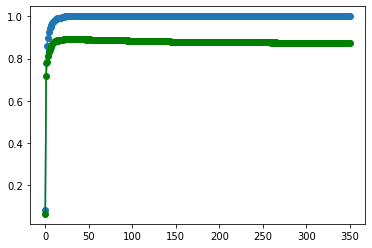

In [135]:
from matplotlib.pyplot import plot

# plot history and see poor generalization
plot(list(range(len(acc_history))), acc_history, 'o-')
plot(list(range(len(test_history))), test_history, 'go-')